# Image Dataset Preparation Guideline

In [1]:
import sys
import tensorflow as tf
import script.myFuction as myFunc

sys.dont_write_bytecode = True

# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Constant Parameters for this `.ipynb` notebook

In [2]:
DATASET_1 = "samples\DATASET\Case1"
DATASET_2 = "samples\DATASET\Case2"
IMAGE_SIZE = 224
BATCH_SIZE = 16

## Method 1: `ImageDataGenerator.flow_from_directory()`

In case, the directory has stucture below
```
DATASET\
├── CLASS A\
|     ├── image1.jpg
|     ├── image2.jpg
├── CLASS B\
|     ├── image3.jpg
|     ├── image4.jpg
...
```
`tf.keras.preprocessing.image.ImageDataGenerator` with `flow_from_directory()` are prefer for this method.

Library requirement for Method 1

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Directory Stucture
myFunc.dir_file_tree(DATASET_1)

├── ILLUST 	 (8 files)
│   ├── ILLUSTRATION (01).jpg
│   ├── ILLUSTRATION (02).jpg
│   ├── ILLUSTRATION (03).jpg
│   ├── ILLUSTRATION (04).jpg
│   ├── ILLUSTRATION (05).jpg
│   ├── ILLUSTRATION (06).jpg
│   ├── ILLUSTRATION (07).jpg
│   ├── ILLUSTRATION (08).jpg
├── MANGA 	 (8 files)
│   ├── MANGA (01).jpg
│   ├── MANGA (02).jpg
│   ├── MANGA (03).jpg
│   ├── MANGA (04).jpg
│   ├── MANGA (05).jpg
│   ├── MANGA (06).jpg
│   ├── MANGA (07).jpg
│   ├── MANGA (08).jpg


For `ImageDataGenerator.flow_from_directory()` arguments
- Put dataset directory to `directory` argument.
- Set `subset` to `'training'` or `'validation'` if`validation_split` in `ImageDataGenerator` is set.
- `class_mode='categorical'` if label is one-hot vector.

In [5]:
datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1.0 / 255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.0),
    rotation_range=0.0,
    zoom_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.1,
)

train_data = datagen.flow_from_directory(
    directory=DATASET_1,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training',
    interpolation='nearest',
)

test_data = datagen.flow_from_directory(
    directory=DATASET_1,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation',
    interpolation='nearest',
)

Found 16 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


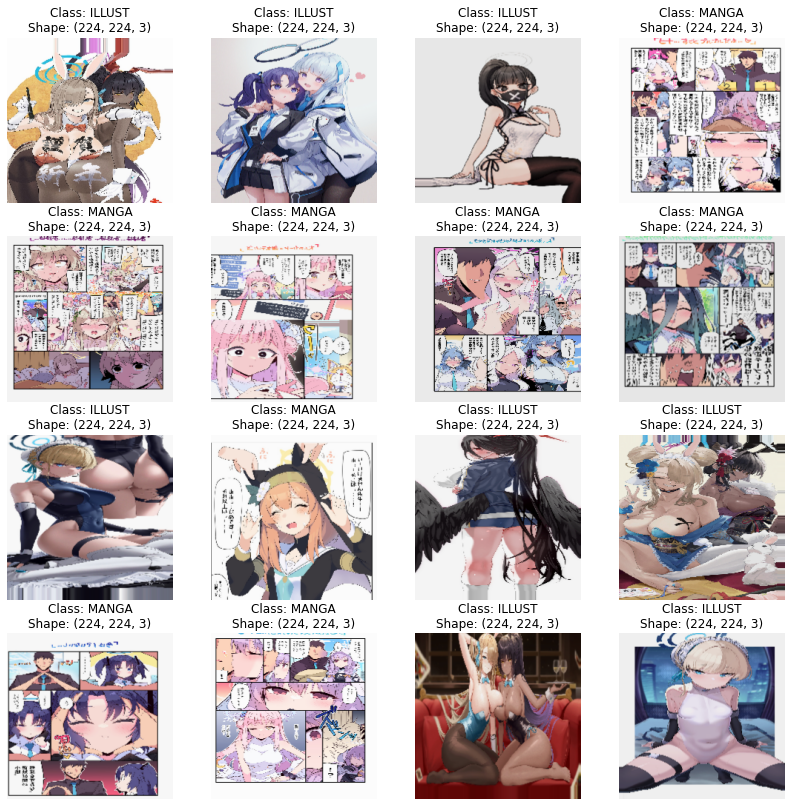

In [6]:
myFunc.view_batch_ImageDataGenerator(train_data, ['ILLUST', 'MANGA'], figsize=(14,14))

However,`ImageDataGenerator` cannot resize image by keeping aspect ratio.

In [7]:
del datagen, train_data, test_data

## Method 2: `ImageDataGenerator.flow_from_dataframe()`

In case, the directory has stucture below
```
DATASET\
├── CLASS A\
|     ├── SUBCLASS A1\
|     |     ├── image1.jpg
|     |     ├── image2.jpg
|     ├── SUBCLASS A2\
|     |     ├── image3.jpg
|     |     ├── image4.jpg
├── CLASS B\
|     ├── image5.jpg
|     ├── image6.jpg
...
```
`tf.keras.preprocessing.image.ImageDataGenerator` with `flow_from_dataframe()` are prefer for this method.

Library requirement for Method 2

In [8]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Directory Stucture
myFunc.dir_file_tree(DATASET_2)

├── BODY
│   ├── BIKINI
│   │   ├── CLASSIC 	 (4 files)
│   │   │   ├── 250439829.png
│   │   │   ├── 250439838.png
│   │   │   ├── 250439842.png
│   │   │   ├── 250439849.png
│   │   ├── FRILLED 	 (4 files)
│   │   │   ├── 250439827.png
│   │   │   ├── 250439834.png
│   │   │   ├── 67284120.png
│   │   │   ├── 67284126.png
│   ├── MAID UNIFORM 	 (4 files)
│   │   ├── 159407210.png
│   │   ├── 159407211.png
│   │   ├── 2674606181.png
│   │   ├── 2674606183.png
├── FACE
│   ├── HAPPY 	 (4 files)
│   │   ├── 244044622.png
│   │   ├── 244044625.png
│   │   ├── 244044626.png
│   │   ├── 244044637.png
│   ├── NEUTRAL 	 (4 files)
│   │   ├── 177929488.png
│   │   ├── 177929489.png
│   │   ├── 177929502.png
│   │   ├── 177929503.png
│   ├── SAD 	 (4 files)
│   │   ├── 716934811.png
│   │   ├── 716934816.png
│   │   ├── 716934821.png
│   │   ├── 716934838.png


First, prepare data list which have `[(path1, label1), (path2, label2), ...]`

In [10]:
data_path_list = [os.path.join(root,image) for root, _, files in os.walk(DATASET_2, topdown=True) for image in files]
data_path_list = [path for path in data_path_list if any(ext in path for ext in (".png", ".jpg"))]
data_path_list = [(path, path.split('\\')[len(DATASET_2.split('\\'))]) for path in data_path_list]

data_path_list[0]

('samples\\DATASET\\Case2\\BODY\\BIKINI\\CLASSIC\\250439829.png', 'BODY')

In [11]:
class_list, dict_class = myFunc.create_dict_class(data_path_list)

Split the data list separately and put into `pandas.DataFrame` 

In [12]:
image_path_list = [path for path, _ in data_path_list]
label_list = [label for _, label in data_path_list]

data = pd.DataFrame({
    'image_paths': image_path_list,
    'labels': label_list  # Custom one-hot encoded labels
})

For `ImageDataGenerator.flow_from_dataframe()` arguments
- `dataframe` will read data from `pandas.DataFrame`
- set dataframe header `image_paths`(for this case) which contain image data to `x_col` 
- set dataframe header `labels`(for this case) which contain image label to `y_col` 

In [13]:
datagen = ImageDataGenerator(
    data_format='channels_last',
    rescale=1.0 / 255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.0),
    rotation_range=0.0,
    zoom_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.1,
)

train_data = datagen.flow_from_dataframe(
    dataframe=data,
    x_col='image_paths',
    y_col='labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

test_data = datagen.flow_from_dataframe(
    dataframe=data,
    x_col='image_paths',
    y_col='labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 22 validated image filenames belonging to 2 classes.
Found 2 validated image filenames belonging to 2 classes.


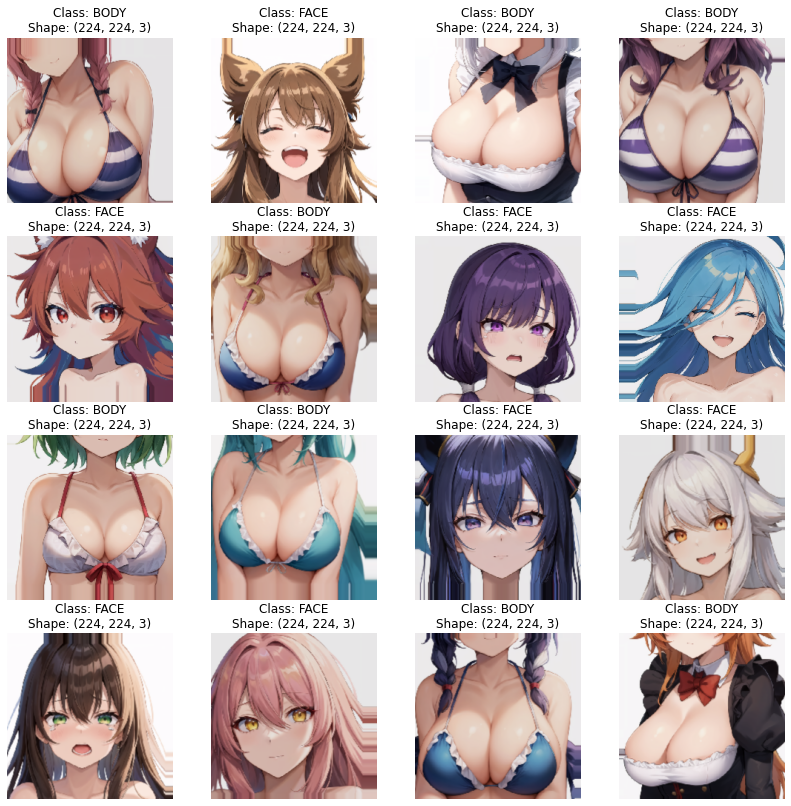

In [14]:
myFunc.view_batch_ImageDataGenerator(train_data, class_list, figsize=(14,14))

The 2nd dataset originally has aspect ratio same as after processing.
So, the images dont take any damage from resizing.

## Method 3: Custom image data generator function

Since `ImageDataGenerator` cannot perform resize image by keeping aspect ratio,
`Custom_ImageDataGenerator` function need to be written by yourself.

In [15]:
def Custom_ImageDataGenerator(image_path, label, image_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations = False)
    image = tf.image.resize(image,
                            (image_size,image_size),
                            #method='bicubic', # Default method='bilinear', 
                            preserve_aspect_ratio=True,
                            antialias=True)
    image = tf.image.resize_with_pad(image,image_size,image_size)
    image = image / 255.0
    
    return image, label

Based on `Custom_ImageDataGenerator` function, it take list of tuple `[(path1, label1, image_size1), (path2, label2, image_size2), ...]` to preprocess image dataset. 

It is similar to Method 2 that list of `image_path` and list of `labels` need to be prepared, but extra list (`image_size`) may require for Method 3. 

Note, It depend on `Custom_ImageDataGenerator` design

In [16]:
data_path_list = [os.path.join(root,image) for root, _, files in os.walk(DATASET_1, topdown=True) for image in files]
data_path_list = [(path, path.split('\\')[-2]) for path in data_path_list]

# Prepare class list and its one-hot vector for next steps
class_list, dict_class = myFunc.create_dict_class(data_path_list)

`validation_split` function need to be written by yourself if you need to split dataset for `training` and `testing`

In [17]:
import random
def validation_split(all_list, ratio=0.1):
    """
    all_list: contain list [(image_path, label)]
    ratio (float): float number in range [0,1]
    """
    class_list = list({class_list for _, class_list in all_list})
    train = []
    test = []
    for class_item in class_list:
        data_class_list = [(path, data_class) for path, data_class in all_list if data_class == class_item]
        test_class_list = random.sample(data_class_list, round(len(data_class_list)*ratio))
        for elem in test_class_list:
            data_class_list.remove(elem)
        train_class_list = data_class_list

        train += train_class_list
        test += test_class_list
    
    return train, test

train_dataset, test_dataset = validation_split(data_path_list)

del data_path_list # Free data for memory

In [18]:
def raw_data_processing(data_list, dict_class, image_size):
    path_list = [path for path, _ in data_list]
    label_list = [dict_class[label] for _, label in data_list]
    size_list = [image_size]*len(label_list)
    return tf.data.Dataset.from_tensor_slices((path_list, label_list, size_list))

In [19]:
# Train dataset
train_dataset = raw_data_processing(train_dataset, dict_class, IMAGE_SIZE)
train_dataset = train_dataset.map(Custom_ImageDataGenerator)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder = True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = raw_data_processing(test_dataset, dict_class, IMAGE_SIZE)
test_dataset = test_dataset.map(Custom_ImageDataGenerator)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE, drop_remainder = False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [20]:
from matplotlib import pyplot as plt
import math
import numpy as np

def view_random_batch_image(dataset, figsize=(14,14)):
    """
    Randomly view image from batch dataset
    """
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        
        # Check how many rows-cols
        base = 2
        while True:
            if math.log(len(images), base) <= 2:
                break   
            base += 1

        for i in range(len(images)):
            plt.subplot(base, base, i + 1)
            plt.imshow((images[i]*255).numpy().astype("uint8"))
            plt.title(f"Class: {class_list[np.argmax(labels[i])]}\nShape: {images[i].shape}")            
            plt.axis("off")
    pass

view_random_batch_image(train_dataset)

<Figure size 1008x1008 with 0 Axes>

However, data augmentation can not be applied to `Custom_ImageDataGenerator`. 

`RandomFlip`, `RandomRotation`, `RandomTranslation`, `RandomZoom`, etc. from `tensorflow.keras.layers` need to be imported and put them into deep learning model while designing.